In [1]:
import numpy as np
import pandas as pd
from scipy.stats import binom
import matplotlib.pyplot as plt
import seaborn as sns
import random
import math

from scipy.interpolate import make_interp_spline
from matplotlib.ticker import FormatStrFormatter

In [2]:
degenerate_symbols = {
    'A' : ['A'],
    'C' : ['C'],
    'G' : ['G'],
    'T' : ['T'],
#    'U' : ['U'],
    'W' : ['A', 'T'],
    'S' : ['C', 'G'],
    'M' : ['A', 'C'],
    'K' : ['G', 'T'],
    'R' : ['A', 'G'],
    'Y' : ['C', 'T'],
    'B' : ['C', 'G', 'T'],
    'D' : ['A', 'G', 'T'],
    'H' : ['A', 'C', 'T'],
    'V' : ['A', 'C', 'G'],
    'N' : ['A', 'C', 'G', 'T'],
    'Z' : [],
}

#aurora_secstruct_positions_0 = [3,5,10,11,13,14,15,16,21,22,25,26,27,28,29,33,36,39,41,42,43,44,45,46]
aurora2 = 'GGAAGGGATGACTATGTCCGGTTCCTGTAAGGCATGTGGAGTGTTGT'
#aurora2_nonconstant = ''.join([aurora2[x] for x in aurora_secstruct_positions_0])

lib_design = [
    'GGAGGRGATGRATRYRYCCGGKHCCRKWWYGGCDTGHGGRGYRYATY',
    'GGAAGRGATGRATRYRYCCGGKHCCRKWWYGGCDTGHGGRGYRYTTY',
    'GGAGGRGATGRCTRYRYCCGGKHCCRKWWYGGCDTGHGGRGYRYAGY',
    'GGAGGRGATGRATRYRYCCGGKHCCYKWWRGGCDTGHGGRGYRYATY',
    'GGAAGRGATGRCTRYRYCCGGKHCCRKWWYGGCDTGHGGRGYRYTGY',
    'GGAAGRGATGRATRYRYCCGGKHCCYKWWRGGCDTGHGGRGYRYTTY',
    'GGAGGRGATGRCTRYRYCCGGKHCCYKWWRGGCDTGHGGRGYRYAGY',
    'GGAAGRGATGRCTRYRYCCGGKHCCYKWWRGGCDTGHGGRGYRYTGY'
]

In [3]:
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['font.size'] = 8
plt.rcParams['font.family'] = 'Arial'

pd.set_option('display.max_colwidth', 100)

colors = {'blue':'#2f788e', 'red':'#d15b4f', 'green':'#45b563'}

In [4]:
def seqDist(s1, s2):
    return sum([1 if b1 != b2 else 0 for b1, b2 in zip(s1, s2)])

In [5]:
def seqGen_ss(libs, n_per_lib):
    seqset = []
    for l in libs:
        seqset += [''.join([random.choice(degenerate_symbols[c]) for c in l]) for i in range(n_per_lib)]
    return seqset

In [6]:
def seqGen_rn(parent, nseqs, mutrate):
    seqs_generated = []
    base_possibilities = {'A':['T', 'C', 'G'], 'T':['A', 'G', 'C'], 'G':['A', 'T', 'C'], 'C':['A', 'T', 'G']}
    for i in range(0, nseqs):
        seqs_generated.append(''.join([random.choice(base_possibilities[ch]) if random.randint(0, 100) < mutrate else ch for ch in parent]))
    return seqs_generated

In [7]:
def numberOfBasepairsConserved(s):
    basepairs = ['AT', 'TA', 'GC', 'CG', 'GT', 'TG']
    basepair_positions = [(10, 46), (11, 45), (13, 43), (14, 42), (15, 41), (16, 39), (17, 38), (18, 37), (23, 31), (24, 30), (25, 29)]

    return sum([1 if s[bp[0]] + s[bp[1]] in basepairs else 0 for bp in basepair_positions])

In [8]:
# Generate sequences.. Secondary structure library and Random mutagenesis library
genseqs_ss = seqGen_ss(lib_design, 100000)
genseqs_rn = seqGen_rn(aurora2, len(genseqs_ss), 21)

# Secondary structure library
df_secstruct_generated = pd.DataFrame({'seq':genseqs_ss})
df_secstruct_generated['dist'] = [seqDist(s, aurora2) for s in df_secstruct_generated['seq']]
df_secstruct_generated['conserved_bp'] = [numberOfBasepairsConserved(s) for s in df_secstruct_generated['seq']]
vc_dists_ss = df_secstruct_generated.value_counts('dist', normalize=True).sort_index()
vc_dists_ss.name = 'ss'
vc_conserved_bp_ss = df_secstruct_generated.value_counts('conserved_bp', normalize=True).sort_index()
vc_conserved_bp_ss.name = 'ss'

# Random mutagenesis
df_randommut_generated = pd.DataFrame({'seq':genseqs_rn})
df_randommut_generated['dist'] = [seqDist(s, aurora2) for s in df_randommut_generated['seq']]
df_randommut_generated['conserved_bp'] = [numberOfBasepairsConserved(s) for s in df_randommut_generated['seq']]
vc_dists_rn = df_randommut_generated.value_counts('dist', normalize=True).sort_index()
vc_dists_rn.name = 'rn'
vc_conserved_bp_rn = df_randommut_generated.value_counts('conserved_bp', normalize=True).sort_index()
vc_conserved_bp_rn.name = 'rn'

In [9]:
df_bp_conservation = pd.concat([vc_conserved_bp_rn, vc_conserved_bp_ss], axis=1).reset_index().sort_values('conserved_bp')
df_dists = pd.concat([vc_dists_rn, vc_dists_ss], axis=1).reset_index().sort_values('dist')

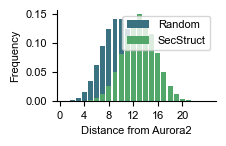

In [10]:
plt.figure(figsize=(2.3, 1.5))
sns.barplot(data=df_dists, x='dist', y='rn', color=colors['blue'], label='Random')
sns.barplot(data=df_dists, x='dist', y='ss', color=colors['green'], label='SecStruct')
plt.xticks([x for x in range(0, 24, 4)])
plt.xlabel('Distance from Aurora2')
plt.ylabel('Frequency')
sns.despine(top=True, right=True)
plt.tight_layout()
plt.savefig('secstruct_vs_rn_dist_distribution.svg')

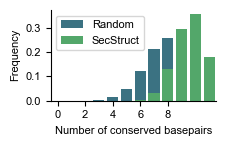

In [11]:
plt.figure(figsize=(2.3, 1.5))
sns.barplot(data=df_bp_conservation, x='conserved_bp', y='rn', color=colors['blue'], label='Random')
sns.barplot(data=df_bp_conservation, x='conserved_bp', y='ss', color=colors['green'], label='SecStruct')
plt.xticks([x for x in range(0, 10, 2)])
plt.xlabel('Number of conserved basepairs')
plt.ylabel('Frequency')
sns.despine(top=True, right=True)
plt.tight_layout()
plt.savefig('secstruct_vs_rn_bp_conservation_distribution.svg')

---


In [12]:
def smoothOut(x, y):
    sp = make_interp_spline(x, y)
    X = np.linspace(min(x), max(x), 200)
    Y = sp(X)
    return X, Y

In [21]:
def distributionComparisonPlot(D, colors=None, labels=None, out_file=None, sample_label=None):
    
    xs = [d.index for d in D]
    ys = [d.values for d in D]
    
    Xs = []
    Ys = []
    for i in range(0, len(D)):
        
        xs_spline, ys_spline = smoothOut(xs[i], ys[i])
        ys_spline = [0 if y < 0 else y for y in ys_spline]
        Xs.append(xs_spline)
        Ys.append(ys_spline)
    
    w = 2
    a = 0.3
    
    # Colors should be set here
    
    fig, ax = plt.subplots(figsize=(2.3, 1.5), layout='tight')
    for i in range(0, len(D)):
        ax.bar(xs[i], ys[i], alpha=a, color=colors[i], label=labels[i])
        ax.plot(Xs[i], Ys[i], linewidth=w, c=colors[i])

    ax.set_xticks([0, 5, 10, 15, 20])
    #ax.set_xticks([0, 4, 8, 12])
    
    ax.set_yticks([0.1, 0.2, 0.3])

    #ax.set_xlim(0, 25)
    ax.set_ylim(0, 0.4)
    
    #ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
    
    ax.text(14, 40, sample_label, fontsize=13, weight="bold")

    #ax.set_title(df_samplesheet.loc[i, 'deoxyribozyme'] + ' ' + str(df_samplesheet.loc[i, 'mut']) + '% mutagenesis')    
    
    #ax.set_xlabel('Number of conserved bps.')
    ax.set_xlabel('Distance from Aurora2')
    
    ax.set_ylabel('Frequency')
    #ax.legend(frameon=False)

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    if out_file == None:
        plt.show()
    else:
        plt.savefig(out_file)

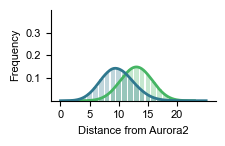

In [22]:
distributionComparisonPlot([vc_dists_ss, vc_dists_rn], colors=[colors['green'], colors['blue']], labels=['S', 'R'], out_file='secstruct_vs_rn_dist_distribution_v2.svg', sample_label=None)

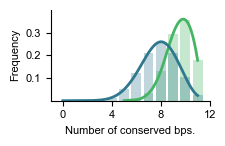

In [20]:
distributionComparisonPlot([vc_conserved_bp_ss, vc_conserved_bp_rn], colors=[colors['green'], colors['blue']], labels=['S', 'R'], out_file='secstruct_vs_rn_bp_conservation_distribution_v2.svg', sample_label=None)